In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("../data/processed/device_level.csv", parse_dates=True, index_col=0)

In [3]:
df.head()

,Home ID,Appliance Type,Energy Consumption (kWh),Outdoor Temperature (°C),Season,Household Size
timestamp,,,,,,
2023-12-02 21:12:00,94,Fridge,0.20,-1.0,Fall,2
2023-08-06 20:11:00,435,Oven,0.23,31.1,Summer,5
2023-11-21 06:39:00,466,Dishwasher,0.32,21.3,Fall,3
2023-01-21 21:56:00,496,Heater,3.92,-4.2,Winter,1
2023-08-26 04:31:00,137,Microwave,0.44,34.5,Summer,5


In [4]:
df.isnull().sum()

Home ID                     0
Appliance Type              0
Energy Consumption (kWh)    0
Outdoor Temperature (°C)    0
Season                      0
Household Size              0
dtype: int64

In [5]:
df.duplicated().sum()

1

In [6]:
df = df[~df.duplicated()]

In [7]:
(df['Energy Consumption (kWh)'] < 0).sum()

0

In [8]:
upper_limit = df['Energy Consumption (kWh)'].quantile(0.99)
df = df[df['Energy Consumption (kWh)'] <= upper_limit]

In [9]:
df['Appliance Type'].nunique()

10

In [17]:
def fill_missing_timestamps(group):
    full_range = pd.date_range(
        start=group.index.min(),
        end=group.index.max(),
        freq='H'
    )
    group = group.reindex(full_range)
    group.index.name = 'timestamp'
    return group.fillna(method='ffill')


In [10]:
hourly_df = (
    df
    .groupby('Appliance Type')
    .resample('H')['Energy Consumption (kWh)']
    .sum()
    .reset_index()
)

In [11]:
hourly_df.head()

,Appliance Type,timestamp,Energy Consumption (kWh)
0,Air Conditioning,2023-01-01 00:00:00,4.42
1,Air Conditioning,2023-01-01 01:00:00,7.61
2,Air Conditioning,2023-01-01 02:00:00,14.80
3,Air Conditioning,2023-01-01 03:00:00,4.19
4,Air Conditioning,2023-01-01 04:00:00,10.68


In [12]:
hourly_df.shape

(87828, 3)

In [13]:
daily_df = (
    df
    .groupby('Appliance Type')
    .resample('D')['Energy Consumption (kWh)']
    .sum()
    .reset_index()
)

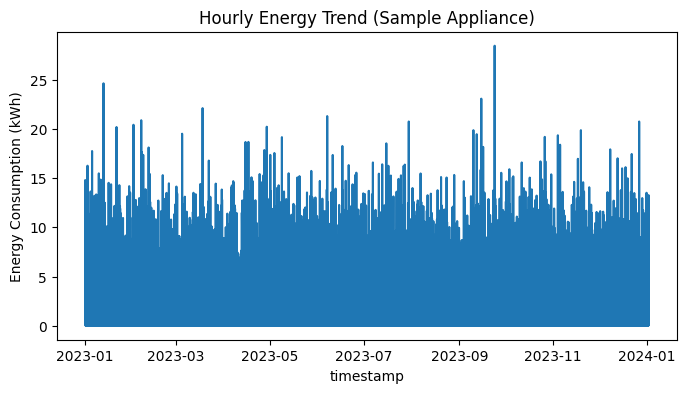

In [14]:
plt.figure(figsize=(8,4))
sns.lineplot(
    data=hourly_df[hourly_df['Appliance Type'] == hourly_df['Appliance Type'].iloc[0]],
    x='timestamp',
    y='Energy Consumption (kWh)'
)
plt.title("Hourly Energy Trend (Sample Appliance)")
plt.show()

In [15]:
full_range = pd.date_range(
    start=df.index.min(),
    end=df.index.max(),
    freq='H'
)
missing_timestamps = full_range.difference(df.index)
len(missing_timestamps)

7251

In [16]:
df = df.reindex(full_range)
df.index.name = 'timestamp'

df = df.fillna(method='ffill')

ValueError: cannot reindex on an axis with duplicate labels

In [16]:
hourly_df.to_csv("../data/processed/hourly_device_energy.csv", index=False)
daily_df.to_csv("../data/processed/daily_device_energy.csv", index=False)